In [5]:
from google.colab import drive ; drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
!pip install transformers==3.4.0
!pip install pytypo
!pip install emoji
!pip install tensorflow==2.2.0
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 1.0MB 10.0MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp36-none-any.whl size=16368 sha256=eab8f6c552868a75aa18ac3d990706b255fb184731894d59ab77b6ca69819a06
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=9adeea6221bf865c77ef9bcd58b595581ae634a5d9443209623e43589ad34fcf
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import pytypo
from re import sub,compile,UNICODE
import emoji
from collections import Counter
import transformers
import pickle
import tensorflow_addons as tfa
import tensorflow as tf
from googletrans import Translator
pd.set_option("max_rows",None)

print(tf.__version__)
print('Keras version: %s' % tf.keras.__version__)
print(f"Transformes {transformers.__version__}")
MAX_LENGTH = 30
AUTO = tf.data.experimental.AUTOTUNE

2.2.0
Keras version: 2.3.0-tf
Transformes 3.4.0


In [11]:
import pandas as pd
dfTrain = pd.read_csv("/content/drive/My Drive/Dataset/penyisihan-datavidia-7-0/train.csv",sep=",")
dfTest = pd.read_csv("/content/drive/My Drive/Dataset/penyisihan-datavidia-7-0/test.csv",sep=",")

In [114]:
dfTrain.loc[14502]

review_id            90d0975755d77f7f77bdfc8f4b75fdb9
review_text    TDK DISARANKAN RESIKO TANGGUNG SENDIRI
category                                            0
Name: 14502, dtype: object

In [79]:
print(f"Row {dfTrain.shape[0]} \n Col {dfTrain.shape[1]}") # row = 14856, col = 3
print(f"Col Names {dfTrain.columns}") 

Row 14856 
 Col 3
Col Names Index(['review_id', 'review_text', 'category'], dtype='object')


In [ ]:
dfTrain = dfTrain.drop(["review_id"] , axis=1) # Dropped
dfTrain.head()

,review_text,category
0,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,bocor lagi,0


In [ ]:
print(f"How Many Nulls  ? {dfTrain['category'].isnull().sum()}") # 0
print(f"How Many Values For 1 and 0 \n{dfTrain['category'].value_counts()} ") # Imbalance (0 : 12839, 1 : 2017)


How Many Nulls  ? 0
How Many Values For 1 and 0 
0    12839
1     2017
Name: category, dtype: int64 


In [8]:
def clean_text(text):

  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[#]+|[^A-Za-z0-9]+"
  text_cleaning_hash = "#[A-Za-z0-9]+" 
  text_cleaning_num = "(^|\W)\d+"

  
  text = sub(text_cleaning_hash, " ", text).strip()
  text = sub(text_cleaning_num, " ", text).strip()
  text = sub(text_cleaning_re, " ", text).strip()
  text = text.lower().strip()
  text = "".join(text.split("."))  
  out = []
  for word in text.split() :
    out.append(word)

  return pytypo.correct_sentence(" ".join(out).strip())

clean_text("cleaning Gan.. 213213902183 httP:////........ ")

NameError: ignored

In [63]:
def clean_emoji(text):
    emoji_patterns = compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=UNICODE)
    return emoji_patterns.sub(r'', text)
print(f"Before :{dfTrain.loc[14492  ,'review_text']}")
clean_emoji(dfTrain.loc[14492  ,"review_text"])


"""with open('/content/drive/My Drive/Emoji_Dict.p', 'rb') as fuf:
  Emoji_Dict = pickle.load(fuf)

Emoji_Dict = {v : k for k,v in Emoji_Dict.items()}
def clean_emoji(text):
  for emot in Emoji_Dict:
    text = sub(r'('+emot+')'," ".join(Emoji_Dict[emot].replace("," , "").replace(":","").split()),text).strip()

  return text
clean_emoji("I won 🥇 in 🏏 gan")"""

Before :kamarnya sempit toilet apalagi water heater y jg ga berfungsi trus nemuin kelabang di lantai kamar dan di atas kasur omg


'with open(\'/content/drive/My Drive/Emoji_Dict.p\', \'rb\') as fuf:\n  Emoji_Dict = pickle.load(fuf)\n\nEmoji_Dict = {v : k for k,v in Emoji_Dict.items()}\ndef clean_emoji(text):\n  for emot in Emoji_Dict:\n    text = sub(r\'(\'+emot+\')\'," ".join(Emoji_Dict[emot].replace("," , "").replace(":","").split()),text).strip()\n\n  return text\nclean_emoji("I won 🥇 in 🏏 gan")'

In [102]:
dfTrain["review_text"] = dfTrain['review_text'].apply(clean_emoji)
dfTrain["review_text"] = dfTrain["review_text"].apply(clean_text)
dfTest["review_text"] = dfTest["review_text"].apply(clean_emoji)
dfTest["review_text"] = dfTest["review_text"].apply(clean_text)
print("Cleaned")

Cleaned


In [ ]:
UniqueWord = set()
forCounter = []
def Uniques(df):
  for i in range(len(df)):
    print(i)
    Listeddesu = df.loc[i,"review_text"].split(" ")
    for j in Listeddesu:
      UniqueWord.add(j)
      forCounter.append(j)
Uniques(dfTrain)

In [ ]:
print(f"There are : {len(UniqueWord)} words" )

There are : 13073 words


In [10]:
ShortWord = []
MediumWord = []

def takeShortestword(word):
  for i in word:
    if len(i) < 5:
      ShortWord.append(i)
  for i in word:
    if len(i) > 5 and len(i) < 8 :
      MediumWord.append(i)
takeShortestword(forCounter)
len(ShortWord) ,len(MediumWord)

(5974, 3605)

In [ ]:
UniqueWord = set()
Uniques(dfTrain)
print(f"There are : {len(UniqueWord)} words" )

There are : 13073 words


In [ ]:
ShortWord = sorted(dict(Counter(ShortWord)).items(),key= lambda dct:dct[1],reverse=True)

In [ ]:
NeedTobefixedWord = []
ConsiderTheWord = []
for i in ShortWord:
  if i[1] > 100:
    NeedTobefixedWord.append(i)
  else:
    ConsiderTheWord.append(i)

len(NeedTobefixedWord),len(ConsiderTheWord)

(140, 2277)

In [7]:
EnglishRow =[91,199,305,342,388,484,490,561,598,878,895,953,1065,1140,1336,1386,1414,1455,1543,1577,1589,1618,1652,1738,1741,1798,1781,1878,
             1904,1919,1969,2144,2273,2349,2476,2533,2714,2754,2794,2814, 2860, 2859, 2929,2970,2988,3070,3167,3259,3281,3289,3291,3402,3504,3535,3549,3567,
             3606,3610,3620,3638,3647,3697,3743,3893,3932,4080,4140,4185,4215,4220,4270,4382,4430,4521,4534,4607,4662,4678,4696,4716,4725,4738,4765,4766,4787,
             4791,4795,4809,4884,4910,4911,4996,5008,5014,5084,5361,5366,5380,5407,5416,5525,5554,5620,5771,5776,5805,5823,5824,5843,5860,5900,5975,6001,6062,6107,6117
             ,6387,6465,6503,6612,6676,6795,6809,6950,7105,7116,7179,7222,7426,7431,7481,7516,7568,7581,7604,7734,7926,8040,8053,8055,8082,8100,8315,8377,8392,8402,8494,
             8601,8653,8691,8719,8865,9032,9039,9129,9142,9240,9260,9421,9458,9486,9497,9474,9586, 9600,9634,9731,9791,9800,9874,9933,10015,10067,10076,10130,10169,
             10237,10245,10269,10335,10348,10435,10520,10566,10729,10753,12550,12656 ,12709 ,12719 ,12822,12980,13039,13104 ,13265 ,13342 ,13349 ,13596 ,13672 ,13732 ,13886,13945,13956,14022, 14073, 14189, 14238, 14301, 14490, 14671, 14678, 14682, 14718, 14731, 14740, 14748, 14812, 14822, 14825, 14840]
EnglishOnlyDf = pd.DataFrame(data=None,columns=["review_text","category"])
for i in EnglishRow:
  EnglishOnlyDf.loc[i]= dfTrain.loc[i,["review_text","category"]]

EnglishOnlyDf.tail(200)
EnglishOnlyDf['review_text'] = EnglishOnlyDf["review_text"].apply(clean_emoji)
EnglishOnlyDf['review_text'] = EnglishOnlyDf["review_text"].apply(clean_text)

EnglishOnlyDf.head()

NameError: ignored

In [90]:
def checkLeakageData():
  leakage = False
  Theindex = []
  for key,val in dfTrain["review_text"].items():
    for key2,val2 in dfTest["review_text"].items():
      if(val == val2):
        leakage=True
        Theindex.append((key,val))
  
  print(f"Leakage ? {leakage}")

  return Theindex
lol = checkLeakageData()

Leakage ? True


In [93]:
lol =sorted(list(set(lol)),key = lambda x :x[0])
lol

[(87, 'biasa aja'),
 (189, 'payah'),
 (192, 'ada harga ada rupa'),
 (218, 'kurang baik'),
 (269, 'kamar mandi kotor'),
 (345, 'ok'),
 (412, 'kasurnya perlu diganti'),
 (460, 'kamar terlalu sempit'),
 (526, 'banyak kecoa'),
 (529, 'fasilitas buruk'),
 (558, 'pelayanan tidak memuaskan'),
 (569, 'air mati'),
 (573, 'lantai berdebu'),
 (775, 'terlalu sempit'),
 (897, 'kamar sempit'),
 (952, ''),
 (979, 'berisik'),
 (1027, 'kamar mandi jorok'),
 (1029, 'berisik'),
 (1049, 'kamar mandi kurang bersih'),
 (1065, 'not recommended'),
 (1076, 'cukuplah'),
 (1194, 'kecewa'),
 (1229, 'kurang bersih'),
 (1269, 'ac kurang dingin'),
 (1278, 'kurang baik pelayanan nya'),
 (1393, 'kurang baik'),
 (1402, 'kamar mandi kotor'),
 (1540, 'sempit'),
 (1719, 'pelayanan'),
 (1749, 'kurang'),
 (1750, 'pegawai kurang ramah'),
 (1859, 'hmm'),
 (1880, 'kamar mandi kotor'),
 (1919, 'not recommended'),
 (1966, 'kebersihan nya kurang'),
 (1984, 'kecewa'),
 (1997, 'pelayanan kurang memuaskan'),
 (2022, 'kamar mandi jor

In [99]:
def RemoveLeakage():
  print(len(dfTrain))
  for i in range(len(lol)):
    try:
      dfTrain.drop(dfTrain.index[lol[i][0]],inplace=True)
    except:
      continue
  print(len(dfTrain))
RemoveLeakage()

14856
14622


In [ ]:
FixtheWord = {"gak":"tidak","tdk":"tidak","dgn":"dengan","bgt":"banget","utk":"untuk","krn":"karena","kmr":"kamar",
               "lha":"lah","sdh":"sudah","udah":"sudah",'kalo':'kalau',"dpt":"dapat","apek" : "bau",
               "ngga":"tidak","trus":"terus","org":"orang","klo":'kalau',"blm":"belum","tau":"tahu","dlm":"dalam"}


In [6]:
"""def FixIt(text):
  text = text.split(" ")
  index= 0
  for i in range(len(text)):
    if (text[i] in FixtheWord.keys()):
      text[i] = FixtheWord[text[i]]
  return " ".join(text)


FixIt("tdk tidak dgn mas")
"""

'def FixIt(text):\n  text = text.split(" ")\n  index= 0\n  for i in range(len(text)):\n    if (text[i] in FixtheWord.keys()):\n      text[i] = FixtheWord[text[i]]\n  return " ".join(text)\n\n\nFixIt("tdk tidak dgn mas")\n'

In [ ]:
"""dfTrain["review_text"] = dfTrain["review_text"].apply(FixIt)"""

In [53]:
"""DeleteRow = [34,48,87,90,141,192,232,249,282,311,345,403,508,660,696,726,753,837,906,952,979,997,
             1029,1056,1072,1076,1104,1114,1261,1271,1297,1353,1364,1614,1689,1719,1749,1840,1859,1883,1922,1927,1949,2095,2195,
             2199,2296,2316,2366,2444,2466,2559,2586,2594,2614,2747,2799,2812,2899,2946,3148,3157,3158,3161,3121,3193,3234,3300,3314,3339,3340,
             3355,3392,3424,3463,3779,3961,3960,3959,3986,4026,4050,4071,4090,4094,4115,4178,4203,4265,4402,4682,4714,4720, 4900,5040,5067,5137,5172,
             5286, 5332,5469,5471,5567,5587,5591,5618,5674,5685,5701,5768,5890,6076,6086, 6169,6178,6279,6427,6436,6511,6515,6536,6687,6802,6823,6921,7031,
             7322,7372,7386,7548,7675,7681,7704,7722,7725,7782,7840,7922, 8036,8076,8139,8141,8191,8335,8435,8475,8523,8552,8758,8808,9005,9245,10214,10218,
             9359,9655,9810,9869,10309,10322,10331,10376,10443,10550,10563,10569,10707,10713,10728,10748,10771,10783,10785,10793
"""
             
             


In [57]:
dfTrain.loc[4213]

review_id      43362523ec579b789f69053ac9d8ff89
review_text                no view no breakfast
category                                      0
Name: 4213, dtype: object

In [55]:
EnglishOnlyDf.head(150)

,review_text,category
952,though their reception number is not reachable...,1
1064,not recommended,0
1139,im expecting hotel service but is not and the ...,0
1335,no food thats why i give point,1
1385,under my expectation that s it,0
1413,nothing special receptionist s serve so badly ...,0
1454,so bad so bad so bad,0
1542,nice room nice moment nice meal,1
1576,check in out was quick so so staffs room is ex...,0
1588,kind of vintage hotel near with many strategic...,1


In [46]:
EnglishOnlyDf.to_csv("EnglishDataTrain.csv",index=False)

In [ ]:
for i in range(9000, 13000):
  print(f" Loc : {i} {dfTrain.loc[i,'review_text'] }" )

 Loc : 9000 airnya ga bisa untuk mandi terlalu kecil mungkin karena lantai paling atas jd airnya ga nyampe tlg diperbaiki untuk airnya agar lebih baik ke depannya
 Loc : 9001 penginapan yang saya inapi namanya hotel satria
 Loc : 9002 jalannya susah masuk2 kampung
 Loc : 9003 tv nya tidak flat tapi tabung saya kecewa
 Loc : 9004 tempat nya bagus bersih dan rapih pelayanan nya cukup bagus
 Loc : 9005 overall its a nice place but i dont really like the bathroom
 Loc : 9006 kurang nyaman terlalu sempit
 Loc : 9007 pelayanan baik sangar ramah tetapi lokasinya susah di cari tapi selebihnya good
 Loc : 9008 wi fi nya tidak connect di dalam kamar nelpon sinyal putus2 dalam kamar remote tv tidak ada kurang bersih agak bising tidak sesuai ma gambar profil tidak nyaman aja
 Loc : 9009 bocorr
 Loc : 9010 untuk kelas eco pelayanan fan fasilitas cukup baik
 Loc : 9011 skrg mahal dan ada deposit nya
 Loc : 9012 chanel tv nya g bs dtonton dengan baik siarannya buruk yg dtrima n dsiarkan
 Loc : 9013 a

In [ ]:
## Build the Deep Learning model
from transformers import AutoTokenizer,TFAutoModel,AutoModel
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
IndoBert = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2")

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,x_val,y_train,y_val = train_test_split(dfTrain["review_text"],dfTrain["category"],test_size=0.03,random_state=102)
len(X_train), len(y_train)
print(y_val.value_counts())

0    373
1     72
Name: category, dtype: int64


In [ ]:
tokens_dfTrain = {
    "review_text": tokenizer.batch_encode_plus(
        X_train.tolist(),
        max_length = MAX_LENGTH,
        pad_to_max_length = True,
        truncation = True)
}
tokens_dfVal = {
    "review_text": tokenizer.batch_encode_plus(
        x_val.tolist(),
        max_length= MAX_LENGTH,
        truncation=True,
        pad_to_max_length= True
    )

    }
train_data ={
        "review_text": tf.convert_to_tensor(tokens_dfTrain["review_text"]["input_ids"]),
        "review_text_mask":tf.convert_to_tensor(tokens_dfTrain["review_text"]["attention_mask"])
}
val_data = {
        "review_text" : tf.convert_to_tensor(tokens_dfVal["review_text"]["input_ids"]),
        "review_text_mask" : tf.convert_to_tensor(tokens_dfVal["review_text"]["attention_mask"])
}
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

y_train = tf.keras.utils.to_categorical(y_train,2)
y_val = tf.keras.utils.to_categorical(y_val,2)
print(y_train[1:5])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
dataset = (tf.data.Dataset.from_tensor_slices((train_data,y_train))
.batch(32)
.prefetch(AUTO))

dataVal = (tf.data.Dataset.from_tensor_slices((val_data,y_val))
.batch(32)
.prefetch(AUTO)
.cache())

In [ ]:
def CreateDLModel():

  ids1 = tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="review_text")
  att1 = tf.keras.layers.Input(shape=(MAX_LENGTH,),dtype=tf.int32,name="review_text_mask")


  embedding,SeqOutput = IndoBert(ids1,attention_mask=att1)

  finlayer = tf.keras.layers.Dropout(0.3)(embedding)
  finlayer = tf.keras.layers.Dense(256,tf.nn.relu)(finlayer)
  finlayer = tf.keras.layers.Dense(64,tf.nn.relu)(finlayer)
  finlayer = tf.keras.layers.Flatten()(finlayer)
  
  
  theFinal = tf.keras.layers.Dropout(0.35)(finlayer)
  theFinal = tf.keras.layers.Dense(16,tf.nn.relu)(theFinal)
  theFinal = tf.keras.layers.Dense(2,activation=tf.nn.softmax)(theFinal)



  final = tf.keras.Model([ids1,att1],[theFinal])
  METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
  ] 
  
  optimizer = tf.keras.optimizers.Adam()
  final.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(),optimizer=optimizer,
               metrics=METRICS)

  for layer in final.layers:
    layer.trainable = False
  for layer in final.layers[-3:]:
      layer.trainable = True

  return final

model = CreateDLModel()

In [ ]:
import math
def create_learning_rate_scheduler(max_learn_rate=1e-2,
                                   end_learn_rate=1e-6,
                                   warmup_epoch_count=3,
                                   total_epoch_count=15):

    def lr_scheduler(epoch):
        if epoch < warmup_epoch_count:
            res = max_learn_rate
        else:
            res = max_learn_rate*math.exp(math.log(end_learn_rate/max_learn_rate)*(epoch-warmup_epoch_count+1)/(total_epoch_count-warmup_epoch_count+1))
        return float(res)
    learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

    return learning_rate_scheduler

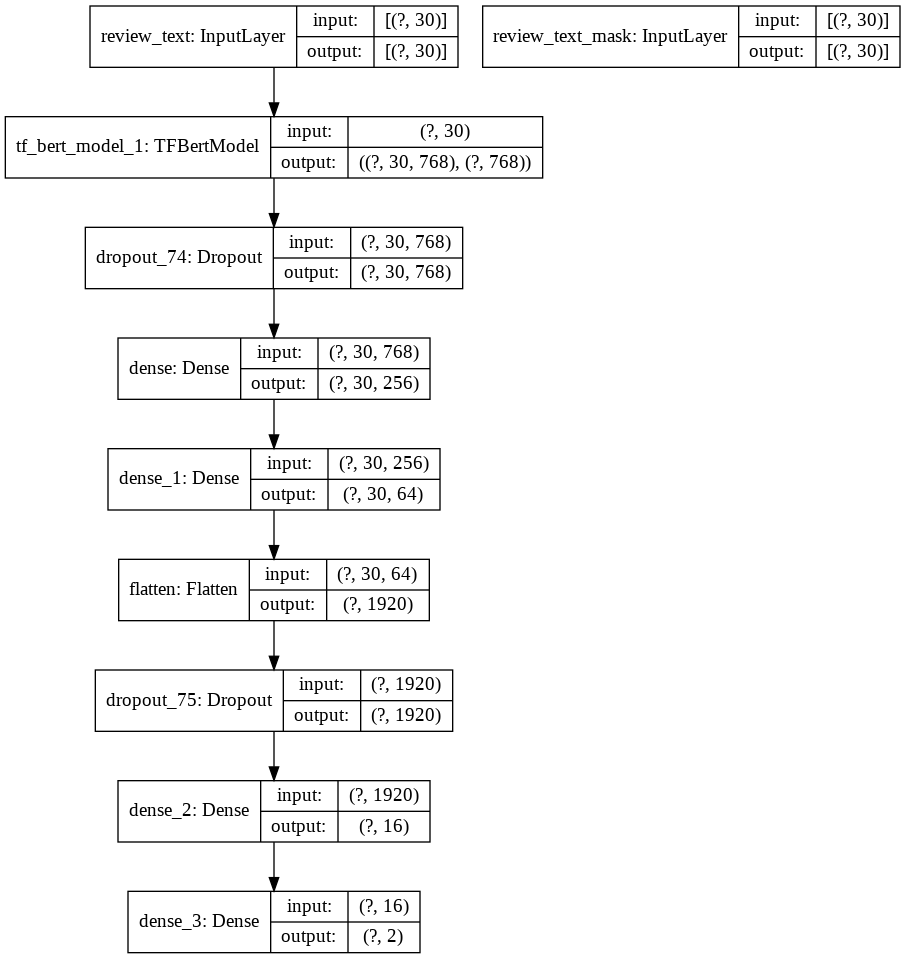

In [ ]:
tf.keras.utils.plot_model(model,"modelarhcitect.png",show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
review_text (InputLayer)        [(None, 30)]         0                                            
__________________________________________________________________________________________________
review_text_mask (InputLayer)   [(None, 30)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 30, 768), (N 124441344   review_text[0][0]                
__________________________________________________________________________________________________
dropout_74 (Dropout)            (None, 30, 768)      0           tf_bert_model_1[0][0]            
______________________________________________________________________________________________

In [ ]:
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience = 6)

In [ ]:
history3=model.fit(x = dataset,epochs = 10,validation_data=dataVal,callbacks = [EarlyStop, create_learning_rate_scheduler(max_learn_rate=1e-4,
                                                    end_learn_rate=1e-6,
                                                    warmup_epoch_count=5,
                                                    total_epoch_count=15),EarlyStop])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/10
450/450 [==============================] - 33s 74ms/step - loss: 0.0978 - tp: 12679.0000 - fp: 1691.0000 - tn: 12679.0000 - fn: 1691.0000 - accuracy: 0.8823 - precision: 0.8823 - recall: 0.8823 - auc: 0.9359 - val_loss: 0.0528 - val_tp: 415.0000 - val_fp: 30.0000 - val_tn: 415.0000 - val_fn: 30.0000 - val_accuracy: 0.9326 - val_precision: 0.9326 - val_recall: 0.9326 - val_auc: 0.9769 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/10
450/450 [==============================] - 30s 67ms/step - loss: 0.0513 - tp: 13446.0000 - fp: 924.0000 - tn: 13446.0000 - fn: 924.0000 - accuracy: 0.9357 - precision: 0.9357 - recall: 0.9357 - auc: 0.9769 - val_loss: 0.0474 - val_tp: 420.0000 - val_fp: 25.0000 - val_tn: 420.0000 - val_fn: 25.0000 - val_accuracy: 0.9438 - val_precision: 0.9438 - val_recall: 0.9438 - val_auc: 0.9794 - lr: 1.0000e-04

Epoch 00003: LearningRateSchedu

In [ ]:
# Test ---
#dfTest["review_text"] = dfTest["review_text"].apply(clean_text)
dfTest["review_text"] = dfTest["review_text"].apply(clean_emoji)
#dfTest["review_text"] = dfTest["review_text"].apply(FixIt)

tokens_dftest = {
    "review_text": tokenizer.batch_encode_plus(
        dfTest["review_text"].tolist(),
        max_length= MAX_LENGTH,
        truncation=True,
        pad_to_max_length= True
    )}

dfTestdataset = {
        "review_text": tf.convert_to_tensor(tokens_dftest["review_text"]["input_ids"]),
        "review_text_mask":tf.convert_to_tensor(tokens_dftest["review_text"]["attention_mask"])
}


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
y_pred = np.argmax(model.predict(dfTestdataset),axis = 1)
y_pred[1:15]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
dfTestAns = pd.DataFrame(dfTest["review_id"])
dfTestAns['category'] =y_pred

In [ ]:
dfTestAns.to_csv("SubmitGan.csv",index=False)

In [ ]:
y_pred2 = np.argmax(model.predict(dfTestdataset),axis = 1)
dfTestAns2 = pd.DataFrame(dfTest["review_id"])
dfTestAns2['category'] =y_pred2

In [ ]:
print(dfTestAns["category"].value_counts() )
print(dfTestAns2['category'].value_counts())

0    3275
1     439
Name: category, dtype: int64
0    3277
1     437
Name: category, dtype: int64


In [ ]:

dfTestAns2.to_csv("SubmitEmojiFixed1.csv",index=False)

In [ ]:
print(dfTestAns["category"].value_counts() )
print(dfTestAns2['category'].value_counts())

0    3275
1     439
Name: category, dtype: int64
0    3244
1     470
Name: category, dtype: int64


In [ ]:
dfTestAns2["category"].value_counts()

0    3218
1     496
Name: category, dtype: int64

In [1]:
for i in range(len(dfTest["review_text"])):
  print(f"loc {i} --> {dfTest.loc[i,'review_text']}")
dfTestEnglish = [23,66,183,227,242,247,293,299,307,319,431,444,462,549,559,569,587,629,648,710,748,761,772,849,893,
                 934,954,1012,1119,1184,1376,1406,1429,1451,1457,1529,1572,1624,1630,1659,1678,1696,1845,1853,1888,1944,
                 1955,1961,2052,2060,2112,2135,2192,2301,2305,2331,2360,2363,2395,2434,2440,2465,2491, 2572,2576,2598,2601,
                 2614,2624,2684,2705,2812,2814,2863,2893,2994,2997,3011,3018,3039,3285,3300,3327,3346,3370,3393,3440,3440,3483,
                3552 ,3565,3607 ,3661

                 ]
                 #3080 < DATA PARAH >
dfTestEnglish.to_csv("TestArk.csv")

NameError: ignored